# Sea-ice function validation, pt. 1
This notebook will run through the validation process for the sea-ice statistics function using just one cell in the Amundsen Sea Embayment (ASE) region. We'll go through the following calculations step-by-step: monthly sea-ice concentration average, monthly sea-ice area sum, and monthly sea-ice area anomaly. As each result is found, it will be compared to the output from the area of interest plot function. 

In [1]:
# import modules
import numpy as np 
import matplotlib.pyplot as plt 
import numpy.ma as ma 
from pyproj import Transformer
import xarray as xr
import cmocean

In [2]:
# load data 
with np.load('ase_sic_12k.npz') as infile:
    sic = np.ma.MaskedArray(data=infile['data'], mask=infile['mask'])
    psx = infile['x']
    psy = infile['y']
    dates = infile['dates']

In [3]:
# load BedMachine Antarctica V2 and extract ice masks

# Path to the BedMachine netCDF file, change this to whereever you save the BedMachine file
bmpath = r'C:\Users\Keyleigh_Walliack\Documents\Amundsen_sea\Sea ice\BedMachineAntarctica_2020-07-15_v02.nc'

# Open the netCDF file
xr_ds = xr.open_dataset(bmpath)

mask = xr_ds.mask.squeeze()

# Convert ocean mask from 0 to nan
mask.data = mask.data.astype('float')
mask.data[mask.data == 0] = 'nan'
    
# Downsample and extract mask for ASE from BedMachine

# Find and round the extent of the ASE sic data to the nearest 1 km
xmin = np.floor(min(psx)/1000)*1000
xmax = np.round(max(psx)/1000)*1000
ymin = np.floor(min(psy)/1000)*1000
ymax = np.round(max(psy)/1000)*1000

# Interpolation interval, meters
dxy = 2500

# Resolution of the sic data, meters
dxy_sic = 12500

# x and y coordinates for interpolating the mask
xx = np.arange(xmin-dxy_sic/2, xmax+dxy_sic/2, dxy)
yy = np.arange(ymin-dxy_sic/2, ymax+dxy_sic/2, dxy)

# Interpolate the mask
mask_int = mask.interp(coords={'x': xx,'y': yy}, method = 'linear')

In [56]:
# define sea-ice function 
def get_sea_ice_stats(x1,y1,x2,y2, sic_arr, dates_arr, psx_arr, psy_arr, day_plot):
    """
    Input PSXY coordinates, in km, of top left and bottom right corners of area of interest. Coordinates must be within the 
    ASE. Input sic, dates, and PSXY arrays and choice of day to plot. Outputs one-day plot of interest area over regional plot
    of the ASE and plots of the area's monthly average sea-ice concentration, monthly average sea-ice area, and monthly sea-ice
    area anomaly.
    """ 
    start = time.time()
    
    ## Find index of PSXY coordinates 
    arr_x = psx_arr
    arr_y = psy_arr
    
    xa = x1 * 1000
    diff_xa = np.absolute(arr_x - xa)
    idx_x1 = diff_xa.argmin()
    
    ya = y1 * 1000
    diff_ya = np.absolute(arr_y - ya)
    idx_y1 = diff_ya.argmin()
     
    xb = x2 * 1000 
    diff_xb = np.absolute(arr_x - xb)
    idx_x2 = diff_xb.argmin()
    
    yb = y2 * 1000
    diff_yb = np.absolute(arr_y - yb)
    idx_y2 = diff_yb.argmin()
    
    xs = [idx_x1, idx_x2]
    ys = [idx_y1, idx_y2]
    
    area_sic = sic_arr[min(ys):max(ys)+1, min(xs):max(xs)+1, :]
    row, col, depth = area_sic.shape # depth = number of days 
    
    # get psxy for area of interest for plotting 
    area_x = psx_arr[min(xs):max(xs)+1]
    area_y = psy_arr[min(ys):max(ys)+1]
     
    ## Output array 1 calculation 
    # find monthly averages of sea-ice concentration
    
    monthly_sic_avgs = [] # output array 1 
    month_labels = []
    
    for j in range(min(dates_arr[:,0]), max(dates_arr[:,0])+1):
                   for i in range(1,13):
                       idx = np.argwhere((dates_arr[:,0] == j) & (dates_arr[:,1] == i))
                       avg = np.nanmean(area_sic[:,:,idx])
                       label = str(j) + '/' + str(i)
                       monthly_sic_avgs = np.append(monthly_sic_avgs,avg)
                       month_labels = np.append(month_labels, label)
    
    # get sea-ice area from sea-ice concentration
    area_sia = np.empty((row, col, depth))
    area_sia[:] = np.nan

    for i in range(depth):
        area_sia[:,:,i] = area_sic[:,:,i]/100 * 12.5**2

    ## Output array 2 calculation 
    # find monthly average sea-ice area  
    
    monthly_sia_avgs = [] # output array 2
    
    months = [] # create list of months
    years = [] # create list of years 
    
    for j in range(min(dates_arr[:,0]), max(dates_arr[:,0])+1):
        for i in range(1,13):
            idx = np.argwhere((dates_arr[:,0] == j) & (dates_arr[:,1] == i))
            total = np.nansum(np.nansum(area_sia[:,:,idx]))
            days = len(idx)
            avg = total / days
            monthly_sia_avgs = np.append(monthly_sia_avgs, avg)
            year = int(j)
            years = np.append(years, year)
            month = int(i)
            months = np.append(months, month)
    
    dates_monthly = np.vstack((years,months)) # creates new dates array that is just months, not daily. output array 4  
    
    ## Output array 3 calculation 
    # find series average of monthly sums for each month
    
    series_avgs = [0] #set first element be zero to simplify indexing for future anomaly calculation
    
    for i in range(1,13):
        idx = np.argwhere((dates_monthly[1] == i))
        avg = np.nanmean(monthly_sia_avgs[idx])
        series_avgs = np.append(series_avgs, avg)

    # calculate monthly total sia anomaly 
    monthly_sia_anoms = [] # output array 3 
    
    year_min = min(dates_monthly[0,:], key=lambda x:float(x))
    year_max = max(dates_monthly[0,:], key=lambda x:float(x))
    
    for j in range(int(year_min), int(year_max)+1):
        for i in range(1,13):
            idx = np.argwhere((dates_monthly[0] == j) & (dates_monthly[1] == i))
            anom = monthly_sia_avgs[idx] - series_avgs[i]
            monthly_sia_anoms = np.append(monthly_sia_anoms, anom)
    
    ## Plot interest area and its monthly avgs (sic), totals (sia), and anomalies (sia)
    
    # index of a day to plot
    area_plot = area_sic[:, :, day_plot]
    ase_plot = sic_arr[:, :, day_plot]
    
    # rectangle for area of interest 
    width = (psx_arr[idx_x2]/1000) - (psx_arr[idx_x1]/1000)
    height = (psy_arr[idx_y1]/1000) - (psy_arr[idx_y2]/1000)
    
    # plot one day
    plt.figure(dpi = 200)
    plt.pcolormesh(psx_arr/1000, psy_arr/1000, ase_plot, cmap=cmocean.cm.ice, shading='nearest', vmin=0, vmax=100)
    cbar = plt.colorbar()
    cbar.set_label('Sea-ice concentration (%)')
    plt.pcolormesh(mask_int.x/1000, mask_int.y/1000, mask_int.data, cmap=cmocean.cm.gray, shading='nearest', vmin=1, vmax=4)
    plt.xlabel('PSX (km)')
    plt.ylabel('PSY (km)')
    plt.gca().add_patch(Rectangle((psx_arr[idx_x1]/1000,psy_arr[idx_y2]/1000), width, height, edgecolor='red', fill=False))
    titletxt = str(dates[day_plot,0]) + '/' + str(dates[day_plot,1]) + '/' + str(dates[day_plot,2])
    plt.title(titletxt)
    plt.axis('equal')
    plt.show()
                                    
    # plot avgs and anomalies 
    length = len(monthly_sic_avgs)
    x = month_labels[0:length+1:6] # labels for x-axis for avg concentration plot
    zeros = np.zeros(length) # for zero slope in anomaly plot
    
    fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(20,20))
    fig.tight_layout(h_pad = 5)
    ax0.plot(month_labels,monthly_sic_avgs, 'darkorange')
    ax0.set_xticks(np.arange(1,length+1,6))
    ax0.set_xticklabels(x,rotation=60)
    ax0.set(title=r'Monthly average sea-ice concentration', ylabel=r'SIC (%)')
    
    ax1.plot(month_labels, monthly_sia_avgs, 'seagreen')
    ax1.set_xticks(np.arange(1,length+1,6))
    ax1.set_xticklabels(x,rotation=60)
    ax1.set(title=r'Monthly average sea-ice area', ylabel=r'SIA ($km^2$)')
    
    ax2.plot(month_labels, monthly_sia_anoms, 'darkviolet')
    ax2.plot(month_labels, zeros, 'k--')
    ax2.set_ybound(upper= np.nanmax(abs(monthly_sia_anoms))+1000, lower=-np.nanmax(abs(monthly_sia_anoms))-1000)
    ax2.set_xticks(np.arange(1, length+1,6))
    ax2.set_xticklabels(x, rotation=60)
    ax2.set(title=r'Monthly sea-ice area anomaly', ylabel=r'SIA ($km^2$)')
    plt.show()
    
    end = time.time()
    print('Elapsed time:', np.round((end-start)*1e6)/1e6, 'seconds.')
    
    return monthly_sic_avgs, monthly_sia_avgs, monthly_sia_anoms, dates_monthly, month_labels
    # optional: save arrays as an npz file
   # np.savez_compressed('interest_area_data.npz', monthly_sic_avgs = monthly_sic_avgs, monthly_sia_avgs = monthly_sia_avgs, 
    #                    monthly_sia_anomaly = monthly_sia_anoms, dates_monthly = dates_monthly)

First, let's find the PSXY coordinates for just one cell. 

In [40]:
arr_x = psx 
arr_y = psy

x1 = -2200 * 1000

diff_arrx1 = np.absolute(arr_x - x1)

idx_x1 = diff_arrx1.argmin()
print("Index of nearest value for x1 is:", idx_x1)

y1 = -800 * 1000

diff_arry1 = np.absolute(arr_y - y1)

idx_y1 = diff_arry1.argmin()
print("Index of nearest value for y1 is:", idx_y1)

x2 = -2212.5 * 1000

diff_arrx2 = np.absolute(arr_x - x2)

idx_x2 = diff_arrx2.argmin()
print("Index of nearest value for x2 is:", idx_x2)

y2 = -813.5 * 1000

diff_arry2 = np.absolute(arr_y - y2)

idx_y2 = diff_arry2.argmin()
print("Index of nearest value for y2 is:", idx_y2)

Index of nearest value for x1 is: 54
Index of nearest value for y1 is: 39
Index of nearest value for x2 is: 53
Index of nearest value for y2 is: 40


Okay, so the one cell we will use are indices 39:40, 53:54. 

In [41]:
# select cell from dataset 
sic_cell = sic[39:40, 53:54, :]

In [42]:
# let's inspect sic of this cell for january of 2006
jun_idx = np.argwhere((dates[:,1] == 6) & (dates[:,0] == 2002)) 

start_idx = int(min(jun_idx)) # set beginning index
end_idx = int(max(jun_idx)) # set ending index 

jun_sic = sic_cell[:,:, start_idx:end_idx+1]

print(jun_sic) # take a look at the values 

[[[72.0 64.0 60.0 78.0 75.0 85.0 84.0 77.0 74.0 61.0 47.0 64.0 61.0 84.0
   97.0 92.0 96.0 83.0 68.0 56.0 59.0 66.0 77.0 84.0 81.0 82.0 78.0 nan
   100.0 100.0]]]


Sea-ice concentration is high as we'd expect in the austral winter. Note: on the 28th of June we have missing data (value 110 = missing data). 

In [43]:
# set missing data to NaN
jun_sic[jun_sic == 110] = 'NaN'

print(jun_sic) # inspect result 

[[[72.0 64.0 60.0 78.0 75.0 85.0 84.0 77.0 74.0 61.0 47.0 64.0 61.0 84.0
   97.0 92.0 96.0 83.0 68.0 56.0 59.0 66.0 77.0 84.0 81.0 82.0 78.0 nan
   100.0 100.0]]]


Now, the missing data has been set to NaN. The previous value of 110 would skew all further calculations. 

In [44]:
# find monthly mean of sic for cell 

jun_sic_avg = np.nanmean(jun_sic)

print(jun_sic_avg) # inspect avg 

76.03448275862068


In [45]:
# find average without mean function to compare 

row, col, depth = jun_sic.shape # set variables for the lengths of each dimension 

sum_j = np.nansum(jun_sic) # sum june sic's 
mean = sum_j / (depth - 1) # divide sum by number of days, excluding 1 NaN day  

print(mean)

76.03448275862068


Great, our averages are the same. 
Now, let's compare this independently calculated mean with the mean from the for loop in the function. 

In [46]:
sic_test = np.copy(sic_cell) 
row, col, depth = sic_test.shape

# set values 110, 120 to NaN 
data = np.ones((row, col))

for i in range(0, depth):
        day = sic_test[:,:,i]
        day[day == 110] = 'NaN' # masks missing data
        day[day == 120] = 'NaN' # masks land 
        day = day 
        data = np.dstack((data, day))

sic_test = data[:,:,1:] # remove filler ones from dataset 

<ipython-input-47-6e137fa4a83a>:8: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(sic_test[:,:,idx])


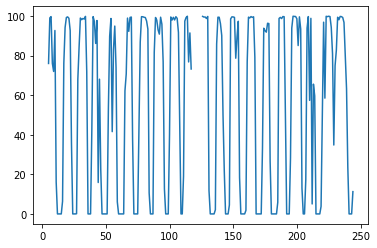

In [47]:
# monthly average for loop from function, labels excluded  

monthly_avgs = []

for j in range(min(dates[:,0]), max(dates[:,0])+1):
    for i in range(1,13):
        idx = np.argwhere((dates[:,0] == j) & (dates[:,1] == i))
        avg = np.nanmean(sic_test[:,:,idx]) 
        monthly_avgs = np.append(monthly_avgs,avg)

# inspect output 
plt.plot(monthly_avgs)

Let's take a look at the first year of the monthly averages. January - May should not have averages as there is no data. The first value should match our average from above. 

In [48]:
test = monthly_avgs[:13]
print(test)

[        nan         nan         nan         nan         nan 76.03448276
 99.06896552 99.70833333 76.08695652 72.         92.7        16.06451613
  0.        ]


Great, our June 2002 sic averages match! 
Now, let's check with the output of the function. 

The indices for the area of interest are 53 : 54 , 39 : 40 .


C:\Users\Keyleigh_Walliack\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:217: UserWarning: Warning: converting a masked element to nan.
  return a.dtype.type(a / b)
<ipython-input-56-eea456c4f439>:90: RuntimeWarning: invalid value encountered in double_scalars
  avg = total / days


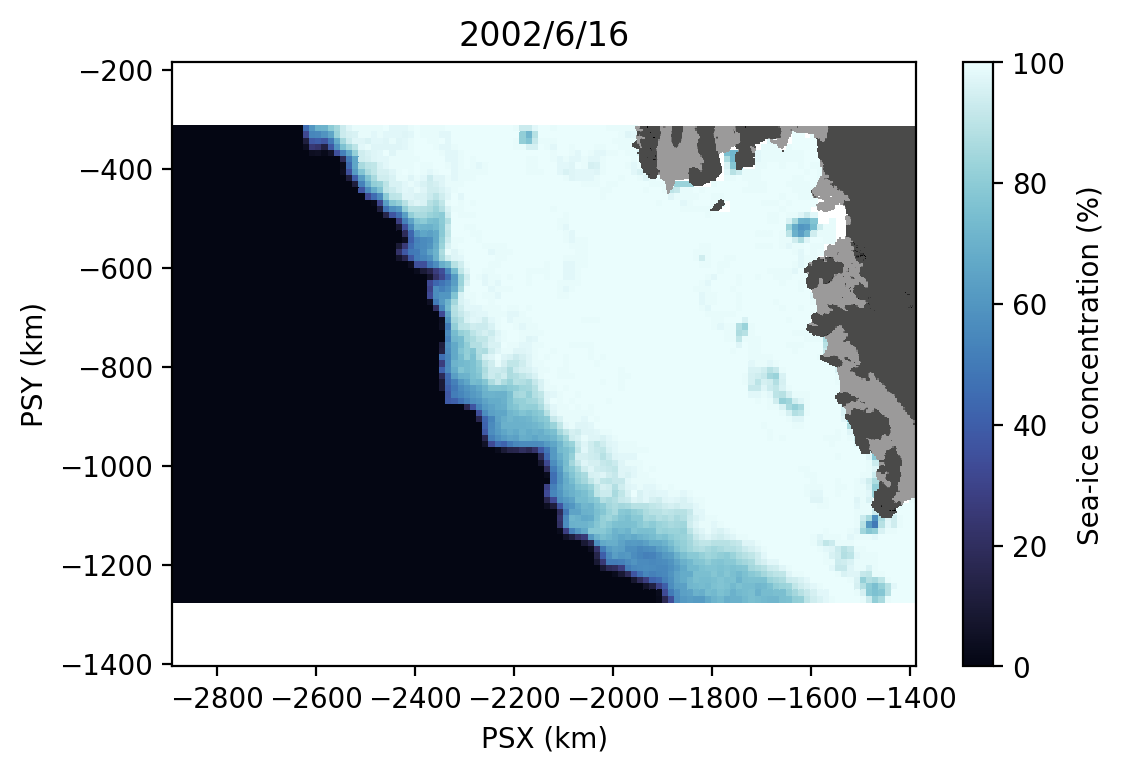

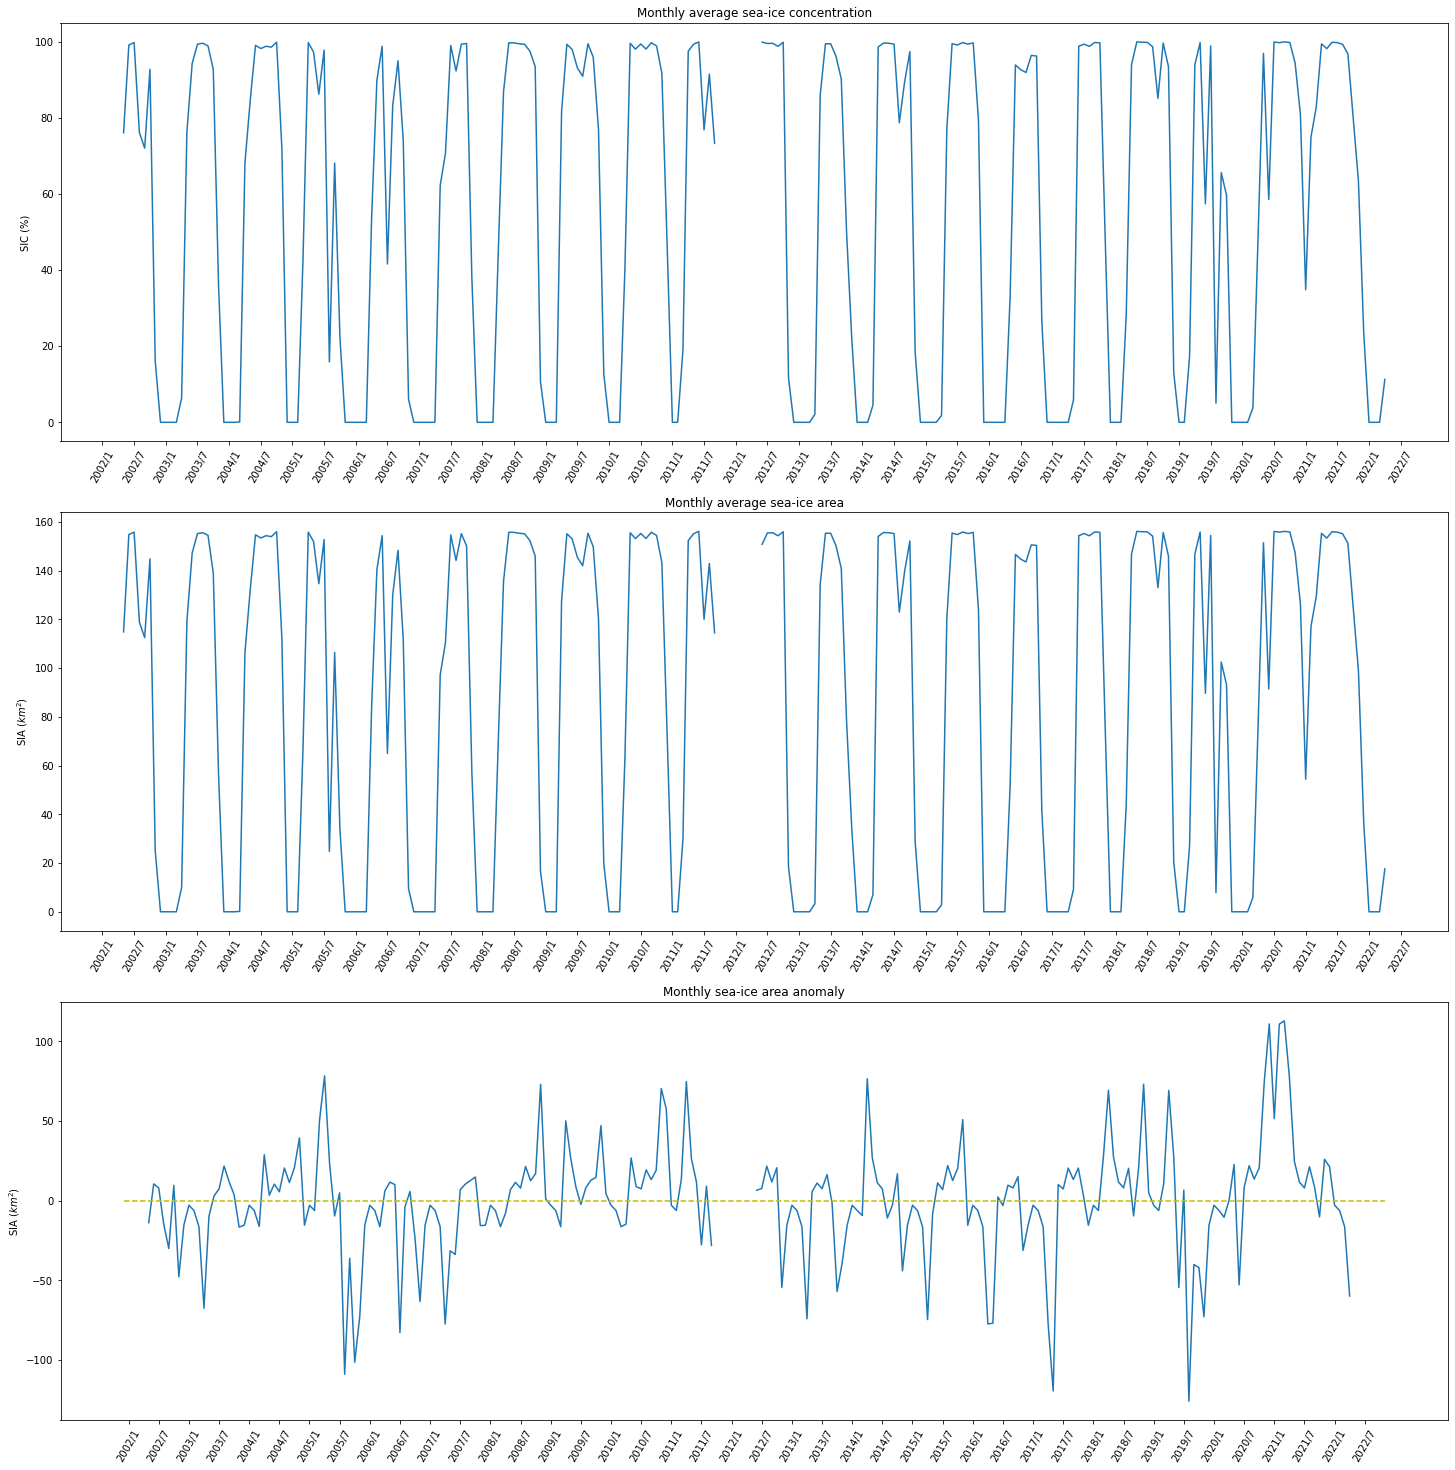

In [58]:
a, b, c, d,e = get_sea_ice_stats(-2212.5, -800, -2212.5, -800, 15, sic, dates, psx, psy)

monthly_sic_avgs_func = a 
monthly_sia_avgs_func = b
monthly_sia_anoms_func = c
dates_monthly = d

In [50]:
# let's take a look at the monthly average output array  
print(monthly_sic_avgs_func[:13])

[        nan         nan         nan         nan         nan 76.03448276
 99.06896552 99.70833333 76.08695652 72.         92.7        16.06451613
  0.        ]


Awesome, all of the June 2002 monthly averages match. 
Now, let's plot the difference between the monthly averages from the for loop (cell 15) and the function output to ensure they are the same.

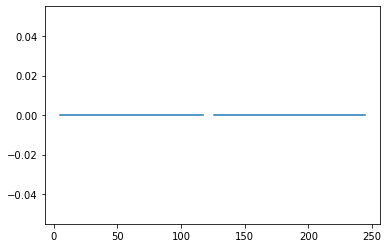

In [51]:
# find difference 
monthly_avg_diff = np.subtract(monthly_avgs, monthly_sic_avgs_func)

# plot difference 
plt.plot(monthly_avg_diff)

The monthly averages match! Let's check out sea-ice area (sia) now. 

In [52]:
sic_cell = np.copy(sic_test) # get 1-cell array with masked cells 

# derive sia from sic 
sia_cell = np.copy(sic_cell)
with np.nditer(sia_cell, op_flags=['readwrite']) as it:
    for x in it:
        x[...] = (x/100) * 12.5**2

In [53]:
# inspect to ensure proper calculation 
print(sic_cell[:,:,:2])
print(sia_cell[:,:,:2])

# independent calculations to double-check 
x = (72/100) * 12.5**2 
o = (64/100) * 12.5**2
print(x,o)

[[[72. 64.]]]
[[[112.5 100. ]]]
112.5 100.0


Looks good! Now, we'll do a similar process to monthly sic averages for monthly sia sums. 

In [54]:
# look at sia in June 2002, use indices from earlier 

jun_sia = sia_cell[:,:, start_idx:end_idx+1]

print(jun_sia) # take a look 

[[[112.5    100.      93.75   121.875  117.1875 132.8125 131.25
   120.3125 115.625   95.3125  73.4375 100.      95.3125 131.25
   151.5625 143.75   150.     129.6875 106.25    87.5     92.1875
   103.125  120.3125 131.25   126.5625 128.125  121.875       nan
   156.25   156.25  ]]]


In [61]:
# find June 2022 sum of sia for cell 
jun_sia_sum = np.nansum(jun_sia)

# find average total sia for June 2002 
row, col, days = jun_sia.shape

jun_avg_sum = jun_sia_sum / days

print('The total sea-ice area for June 2002 was', int(jun_sia_sum), 'km\u00b2,', 'and the average sea-ice area was', int(jun_avg_sum), 'km\u00b2.')

The total sea-ice area for June 2002 was 3445 km², and the average sea-ice area was 114 km².


We have our monthly sia sum just for June 2002. Let's find all monthly sums for the dataset. 

<ipython-input-66-52af754c480a>:12: RuntimeWarning: invalid value encountered in double_scalars
  avg = total / days


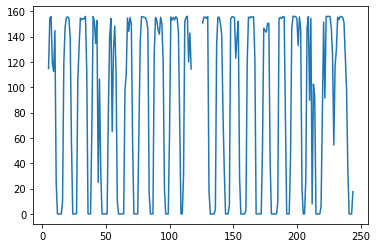

In [66]:
# calculate monthly sia averages
monthly_sia_avgs = [] 

years = []
months = []
  
for j in range(min(dates[:,0]), max(dates[:,0])+1):
    for i in range(1,13):
        idx = np.argwhere((dates[:,0] == j) & (dates[:,1] == i))
        total = np.nansum(np.nansum(sia_cell[:,:,idx]))
        days = len(idx)
        avg = total / days
        monthly_sia_avgs = np.append(monthly_sia_avgs, avg)
        y = int(j)
        years = np.append(years, y)
        m = int(i)
        months = np.append(months, m)

mdates = np.vstack((years, months))      

# plot to inspect 
plt.plot(monthly_sia_avgs)

Let's take a look at the first year of monthly sums. January - May should not have sums. The first value should match our sum from above. 

In [67]:
test = monthly_sia_avgs[:13]
print(test)

[         nan          nan          nan          nan          nan
 114.84375    154.79525862 155.79427083 118.88586957 112.5
 144.84375     25.10080645   0.        ]


They match! Now, let's check out the function output of monthly sums. 

In [68]:
print(monthly_sia_avgs_func[:13])

[         nan          nan          nan          nan          nan
 114.84375    154.79525862 155.79427083 118.88586957 112.5
 144.84375     25.10080645   0.        ]


Another match. Let's plot their difference now. 

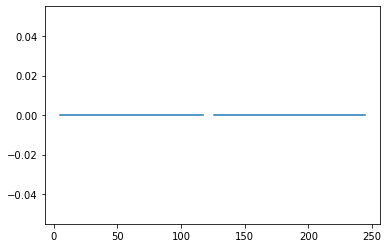

In [69]:
# find difference 
monthly_sia_avg_diff = np.subtract(monthly_sia_avgs, monthly_sia_avgs_func)

# plot 
plt.plot(monthly_sia_avg_diff)

The function output and independently calculated monthly sums match!
Finally, let's verify the monthly sia anomaly calculation. 

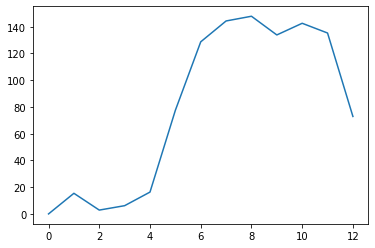

In [71]:
# find average sia for each month in the dataset 
series_avgs = [0]

for i in range(1,13):
    idx = np.argwhere((mdates[1] == i))
    total = np.nanmean(monthly_sia_avgs[idx])
    series_avgs = np.append(series_avgs, total)
    
# plot to inspect 
plt.plot(series_avgs)

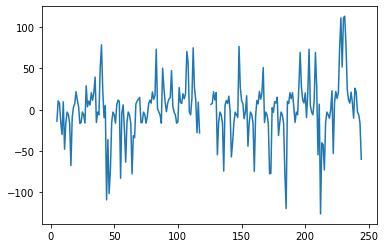

In [72]:
# calculate monthly anomaly 
monthly_anoms = []

year_min = min(dates_monthly[0,:],key=lambda x:float(x))
year_max = max(dates_monthly[0,:],key=lambda x:float(x))

for j in range(int(year_min), int(year_max)+1):
    for i in range(1,13):
        idx = np.argwhere((mdates[0] == j) & (mdates[1] == i))
        anom = monthly_sia_avgs[idx] - series_avgs[i]
        monthly_anoms = np.append(monthly_anoms, anom)
        
# inspect result
plt.plot(monthly_anoms)

Let's inspect the first year of the independently calculated monthly anomaly with the function output. 

In [73]:
test = monthly_anoms[:13]
print(test)

[         nan          nan          nan          nan          nan
 -13.81030702  10.53709851   8.00455729 -14.92561141 -30.02891668
   9.59380672 -47.76899406 -15.41542869]


In [74]:
print(monthly_sum_anoms_func[:13])

[         nan          nan          nan          nan          nan
 -13.81030702  10.53709851   8.00455729 -14.92561141 -30.02891668
   9.59380672 -47.76899406 -15.41542869]


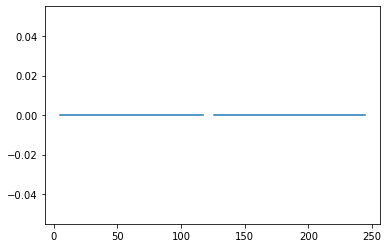

In [75]:
# find difference 
monthly_anom_diff = np.subtract(monthly_anoms, monthly_sum_anoms_func)

# plot 
plt.plot(monthly_anom_diff)

Great! We have now gone through each of the plots within the 'area of interest' plot function. All three outputs match our independent calculations. 
In part 2 of this validation process, we will verify the output plots with the whole ASE area, rather than just one cell. 